# 標準神經網路做手寫辨識


## 使用Keras(Tensorflow 1.X版本)示範
- 這邊先以Tensorflow 1.X版本進行示範


###  1. 初始準備

Keras 可以用各種不同的深度學習套件當底層, 我們在此指定用 Tensorflow 以確保執行的一致性。

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


再來是我們標準數據分析動作!

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### 2. 讀入 MNIST 數據庫

MNIST 是有一堆 0-9 的手寫數字圖庫。有 6 萬筆訓練資料, 1 萬筆測試資料。它是 "Modified" 版的 NIST 數據庫, 原來的版本有更多資料。這個 Modified 的版本是由 LeCun, Cortes, 及 Burges 等人做的。可以參考這個數據庫的[原始網頁](http://yann.lecun.com/exdb/mnist/)。

MNIST 可以說是 Deep Learning 最有名的範例, 它被 Deep Learning 大師 Hinton 稱為「機器學習的果蠅」。

#### 2.1 由 Keras 讀入 MNIST

Keras 很貼心的幫我們準備好 MNIST 數據庫, 但現在會建議要升級為 TensorFlow 2.x版，這在第二部分再使用。

In [3]:
from keras.datasets import mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


我們來看看訓練資料是不是 6 萬筆、測試資料是不是有 1 筆。

In [5]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

60000
60000
10000
10000


#### 2.2 數據庫的內容



每筆輸入 (x) 就是一個手寫的 0-9 中一個數字的圖檔, 大小為 28x28。而輸出 (y) 當然就是「正確答案」。我們來看看訓練資料。

In [6]:
x_train[9487].shape

(28, 28)

因為是圖檔, 當然可以顯示出來!

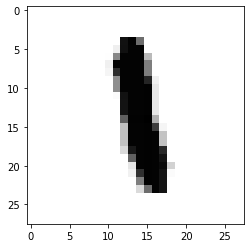

In [7]:
plt.imshow(x_train[9487], cmap='Greys')

In [8]:
x_train[9487]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 240,
        253, 165,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  32, 241,
        252, 252,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

我們人眼辨識就知道這是 1, 我們看答案是不是和我們想的一樣。

In [9]:
y_train[9487]

1

#### 2.3 輸入格式整理

我們現在要用標準神經網路學學手寫辨識。原來的每筆數據是個 28x28 的矩陣 (array), 但標準神經網路只吃「平平的」, 也就是每次要 28x28=784 長的向量。因此我們要用 `reshape` 調校一下。

In [10]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

#### 2.4 輸出格式整理

我們可能會想, 我們想學的函數是這樣的型式:

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}$$

其實這樣不太好! 為什麼呢? 比如說我們的輸入 x 是一張 0 的圖, 因為我們訓練的神經網路總會有點誤差, 所以可能會得到:

$$\hat{f}(x) = 0.5$$

那這意思是有可能是 0, 也有可能是 1 嗎!!?? 可是 0 和 1 根本不像啊。換句話說分類的問題這樣做其實不合理!

於是我們會做 "1-hot enconding", 也就是

* 1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
* 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0]

等等。因為分類問題基本上都要做這件事, Keras 其實已幫我們準備好套件!

In [11]:
from keras.utils import np_utils

In [12]:
y_train = np_utils.to_categorical(y_train,10)

In [13]:
y_test = np_utils.to_categorical(y_test,10)

我們來看看剛剛是 1 的 9487 號數據的答案。

In [14]:
y_train[9487]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

和我們想的一樣! 至此我們可以打造我們的神經網路了。

### 3.打造第一個神經網路



我們決定了我們的函數是

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}^{10}$$

這個樣子。而我們又說第一次要用標準神網路試試, 所以我們只需要再決定要幾個隱藏層、每層要幾個神經元, 用哪個激發函數就可以了。



#### 3.1 決定神經網路架構、讀入相關套件



假如我們要這麼做:

* 使用 <span style="color:red;">2</span> 個 hidden layers
* 每個 hidden layer 用 <span style="color:red;">500</span> 個神經元
* Activation Function 唯一指名 <span style="color:red;">sigmoid</span>

於是從 Keras 把相關套件讀進來。

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

#### 3.2 建構我們的神經網路

和以前做迴歸或機器學習一樣, 我們就打開個「函數學習機」。標準一層一層傳遞的神經網路叫 `Sequential`, 於是我們打開一個空的神經網路。

In [16]:
model = Sequential()

我們每次用 `add` 去加一層, 從第一個隱藏層開始。而第一個隱藏層因為 Keras 當然猜不到輸入有幾個 features, 所以我們要告訴它。

In [17]:
model.add(Dense(500, input_dim=784))
model.add(Activation('sigmoid'))

第二層 hidden layer 因為前面輸出是 500, 現在輸入是 500, 就不用再說了! 這裡的 500 只告訴 Keras, 我們第二層還是用 500!

In [18]:
model.add(Dense(500))
model.add(Activation('sigmoid'))

輸出有 10 個數字, 所以輸出層的神經元是 10 個! 而如果我們的網路輸出是 

$$(y_1, y_2, \ldots, y_{10})$$

我們還希望

$$\sum_{i=1}^{10} y_i = 1$$

這可能嗎, 結果是很容易, 就用 `softmax` 當激發函數就可以!!

In [19]:
model.add(Dense(10))
model.add(Activation('softmax'))

至此我們的第一個神經網路就建好了!

#### 3.3 組裝

繼續將 `compile`建立才正式把我們的神經網路建好。你可以發現我們還需要做幾件事:

* 決定使用的 loss function, 一般是 `mse`
* 決定 optimizer, 我們用標準的 SGD
* 設 learning rate

為了一邊訓練一邊看到結果, 我們加設

    metrics=['accuracy']
    
本行基本上和我們的神經網路功能沒有什麼關係。

In [20]:
model.compile(loss='mse', optimizer=SGD(lr=0.1), metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### 4. 檢視我們的神經網路

我們可以檢視我們神經網路的架構, 可以確認一下是不是和我們想像的一樣。

#### 4.1 看 model 的 summary

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               392500    
                                                                 
 activation (Activation)     (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 activation_1 (Activation)   (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5010      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 648,010
Trainable params: 648,010
Non-trai

#### 4.2 畫出結構圖

要使用這個功能要安裝 `pydot` 及 `graphviz` 兩個套件,Colab已經有包含。

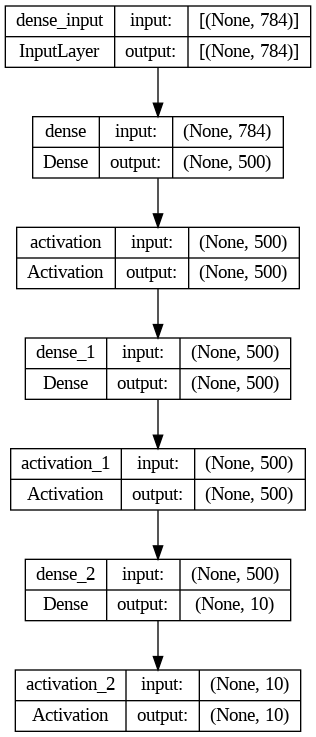

In [22]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model01.png')

### 5. 訓練你的第一個神經網路


恭喜! 我們完成了第一個神經網路。這裡我們還有兩件事要決定:

* 一次要訓練幾筆資料 (`batch_size`)?
* 資料一共要訓練幾次 (`epochs`)?

於是最精彩的就來了。你要有等待的心理準備...

In [23]:
model.fit(x_train, y_train, batch_size=100, epochs=20)

Epoch 1/20
600/600 [==============================] - 8s 6ms/step - loss: 0.0825 - accuracy: 0.3675
Epoch 2/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0635 - accuracy: 0.6386
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0454 - accuracy: 0.7828
Epoch 4/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0327 - accuracy: 0.8487
Epoch 5/20
600/600 [==============================] - 3s 6ms/step - loss: 0.0252 - accuracy: 0.8760
Epoch 6/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0211 - accuracy: 0.8899
Epoch 7/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0185 - accuracy: 0.8986
Epoch 8/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0167 - accuracy: 0.9057
Epoch 9/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0154 - accuracy: 0.9118
Epoch 10/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0145 - accuracy: 0.9162

### 6. 試用我們的結果


In [24]:
from ipywidgets import interact_manual

我們 "predict" 放的是我們神經網路的學習結果。這裡用 `predict_classes` 會讓我們 Keras 選 10 個輸出機率最大的那類。

In [26]:
#predict = model.predict_classes(x_test)
predict = np.argmax(model.predict(x_test), axis=-1)

313/313 [==============================] - 1s 1ms/step


不要忘了我們的 `x_test` 每筆資料已經換成 784 維的向量, 我們要整型回 28x28 的矩陣才能當成圖形顯示出來!

In [27]:
def test(測試編號):
  plt.imshow(x_test[測試編號].reshape(28,28), cmap="Greys")
  print("神經網路判斷為:", predict[測試編號])

In [28]:
interact_manual(test, 測試編號 = (0, 9999));

interactive(children=(IntSlider(value=4999, description='測試編號', max=9999), Button(description='Run Interact', …

到底測試資料總的狀況如何呢? 我們可以給我們神經網路「考一下試」。

In [29]:
score = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0108 - accuracy: 0.9317


In [30]:
print('測試資料的 loss:', score[0])
print('測試資料正確率:', score[1])

測試資料的 loss: 0.010770943947136402
測試資料正確率: 0.9316999912261963


### 7. 訓練好的神經網路存起來!

如果對訓練成果滿意, 我們當然不想每次都再訓練一次! 我們可以把神經網路的架構和訓練好的參數都存起來, 以供日後使用!

之前還沒裝 pyh5 要在終端機 (Anaconda Prompt) 下安裝:
    
    conda install h5py

In [31]:
model_json = model.to_json()
# open('./data/handwriting_model_architecture.json', 'w').write(model_json)
model.save_weights('handwriting_model_weights.h5')

## 使用Tensorflow 2.X版本(服裝圖像分析)


- TensorFlow 2.0 has been [released](https://tensorflow.org)!

- Colab預設為TensorFlow 1.x 版，但建議逐步改為 TensorFlow 2.x 版


###  0. 切換為2.X版(需要重啟)

### 1. 確認版本

- 切換為2.X版(需要重啟)

In [32]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [33]:
import tensorflow as tf

print(tf.__version__)

2.11.0


In [34]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### 2.載入數據

#### 數據說明

- 本次使用 [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)資料集，一樣包含70,000個衣服圖像、分為10種類別，同樣為28*28像素、灰階。
![](https://tensorflow.org/images/fashion-mnist-sprite.png)
 
 - 你可以當作這就是衣服版的手寫辨識資料及，但比手寫版MNIST更具挑戰。
 - 我們接著同樣用60,000張圖像來訓練網絡，並使用10,000張圖像來評估網絡學習對圖像進行分類的準確程度。


`train_labels`與`test_labels`分為10類:

|Label| Class|中文|
|-|-|-
0|T-shirt/top|T恤/上衣
1|Trouser|褲
2|Pullover|套衫
3|Dress|連衣裙
4|Coat|外套
5|Sandal|涼鞋
6|Shirt|襯衫
7|Sneaker|運動鞋
8|Bag|包
9|Ankle boot|踝靴

In [35]:
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [36]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 3. 探索資料EDA

In [37]:
train_images.shape

(60000, 28, 28)

In [38]:
print(len(train_images))
print(len(train_labels))
print(len(test_images))
print(len(test_labels))

60000
60000
10000
10000


每個標籤都是0到9之間的整數

In [39]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

每個圖像都表示為28 x 28像素

In [40]:
test_images.shape

(10000, 28, 28)

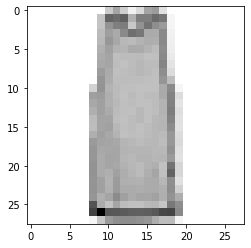

In [41]:
plt.imshow(train_images[9487], cmap='Greys')

In [42]:
train_labels[9487]

0

### 4. 預處理 Preprocess the data

在訓練網絡之前，必須對數據進行預處理。如果檢查訓練集中的第一張圖像，您將看到像素值落在0到255的範圍內：

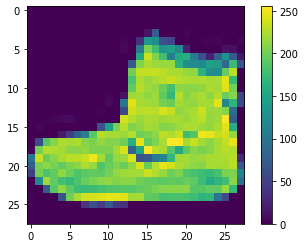

In [43]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

在將它們輸入神經網絡模型之前，將這些值縮放到0到1的範圍。為此，將值除以255。以相同的方式預處理訓練集和測試集非常重要

In [44]:
train_images = train_images / 255.0

test_images = test_images / 255.0

為了驗證數據的格式正確，並準備好構建和訓練網絡，讓我們顯示訓練集中的前25張圖像，並在每個圖像下方顯示類別名稱。

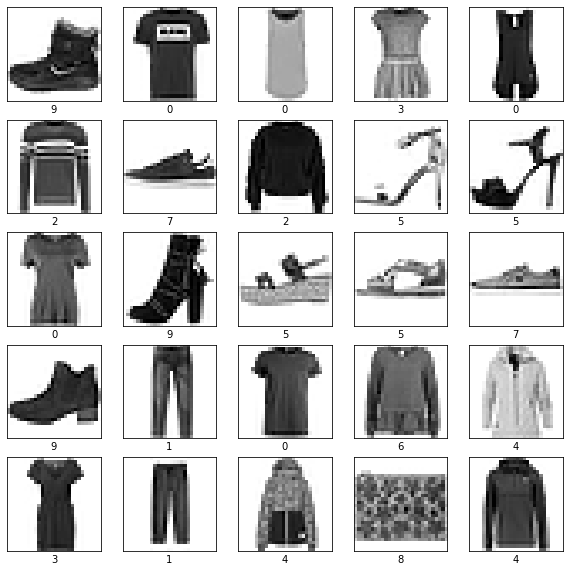

In [45]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

### 5. 建立模型

#### 設定模型網路層、激勵函數

In [46]:
model = keras.Sequential([
                          keras.layers.Flatten(input_shape=(28, 28)),
                          keras.layers.Dense(500, activation='sigmoid'),
                          keras.layers.Dense(500, activation='relu'),
                          keras.layers.Dense(10, activation='softmax')
                          ])

#### 編譯模型

In [47]:
from keras.optimizers import SGD

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

#### 檢視模型

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 500)               392500    
                                                                 
 dense_4 (Dense)             (None, 500)               250500    
                                                                 
 dense_5 (Dense)             (None, 10)                5010      
                                                                 
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


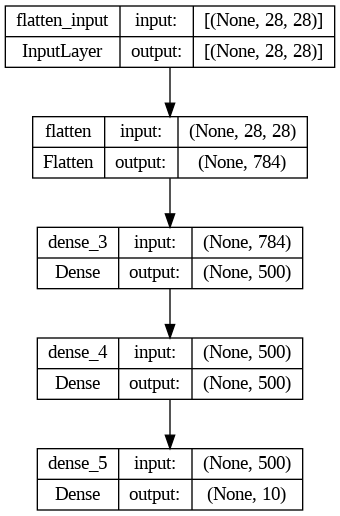

In [49]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='model02.png')

#### 訓練模型

In [50]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.5047 - accuracy: 0.8158
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3697 - accuracy: 0.8644
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3280 - accuracy: 0.8785
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2989 - accuracy: 0.8881
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2768 - accuracy: 0.8953
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2593 - accuracy: 0.9025
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2426 - accuracy: 0.9079
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2300 - accuracy: 0.9129
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2176 - accuracy: 0.9173
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.206

#### 評估準確性

接下來，比較模型在測試數據集上的表現：
- 測試數據集的準確性略低於訓練數據集的準確性。訓練準確性和測試準確性之間的差距代表過度擬合。

In [51]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3193 - accuracy: 0.8903 - 695ms/epoch - 2ms/step

Test accuracy: 0.8902999758720398


#### 做出預測

In [52]:
predictions = model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


- 最有信心的最高值即為預測結果

In [53]:
predictions[9527]

array([2.0103038e-03, 9.4994066e-09, 9.9508721e-01, 1.0807910e-05,
       1.0097218e-03, 6.4462204e-09, 1.8817944e-03, 2.1830826e-09,
       1.1273635e-07, 7.1483069e-10], dtype=float32)

In [54]:
np.argmax(predictions[9527])

# 2，Pullover	套衫

2

In [55]:
test_labels[9527]

2

- 以圖形方式查看10個類別預測

In [56]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

讓我們看一下第0張圖片，預測和預測數組。正確的預測標籤為藍色，錯誤的預測標籤為紅色。該數字給出了預測標籤的百分比（滿分為100）。

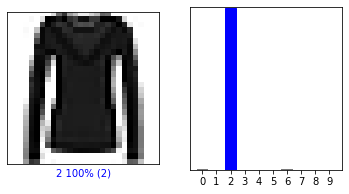

In [57]:
i = 9527
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

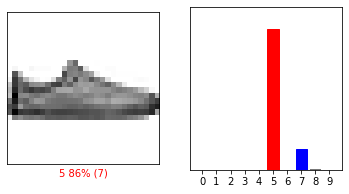

In [58]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

讓我們繪製一些帶有預測的圖像。請注意，即使非常自信，該模型也可能是錯誤的。

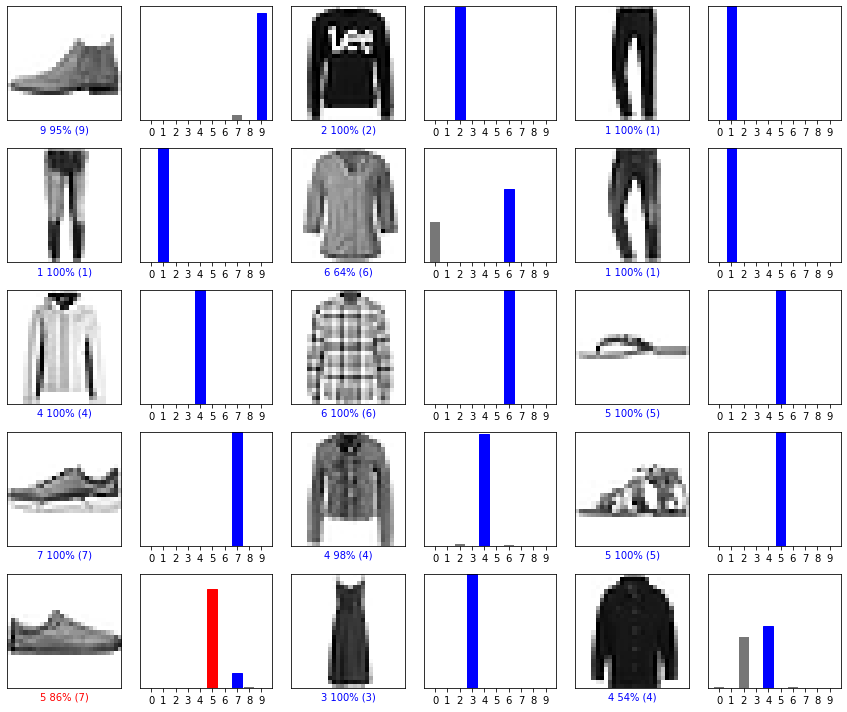

In [59]:
# Plot the first X test images, their predicted labels, and the true labels.
#正確預測為藍色、不正確預測為紅色
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

### reference
- 蔡炎龍老師的Deep Learning MOOC 教學
- https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb#scrollTo=DvYmmrpIy6Y1